## ART BlackBox Classifier

This demo consists of two parts. The first part trains and saves the weights of a simple neural network for the MNIST dataset. The second attacks the deployed model with the HopSkipJump attack using only the model predictions.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt

from art import config
from art.estimators.classification import BlackBoxClassifier
from art.attacks.evasion import HopSkipJump
from art.utils import to_categorical
from art.utils import load_dataset, get_file, compute_accuracy

### Create and Train a model

In this first part of the demo, we train a simple model and train it using the MNIST dataset. This code is largely taken and modified from the tutorial found here: https://www.tensorflow.org/tutorials/keras/save_and_load 

In [2]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.4.1


In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
num_train = 10000
train_labels = train_labels[:num_train]
test_labels = test_labels[:num_train]

train_images = train_images[:num_train].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:num_train].reshape(-1, 28 * 28) / 255.0

In [4]:
# Define a simple sequential model
def create_model():
  model = tf.keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10)
  ])

  model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.metrics.SparseCategoricalAccuracy()])

  return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [5]:
checkpoint_path = "../training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(train_images, 
          train_labels,  
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Epoch 1/10
313/313 [==============================] - 10s 30ms/step - loss: 0.6848 - sparse_categorical_accuracy: 0.8024 - val_loss: 0.2491 - val_sparse_categorical_accuracy: 0.9267

Epoch 00001: saving model to ../training_1/cp.ckpt
Epoch 2/10
313/313 [==============================] - 7s 21ms/step - loss: 0.2022 - sparse_categorical_accuracy: 0.9431 - val_loss: 0.2072 - val_sparse_categorical_accuracy: 0.9363

Epoch 00002: saving model to ../training_1/cp.ckpt
Epoch 3/10
313/313 [==============================] - 6s 19ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.9631 - val_loss: 0.1609 - val_sparse_categorical_accuracy: 0.9514

Epoch 00003: saving model to ../training_1/cp.ckpt
Epoch 4/10
313/313 [==============================] - 6s 20ms/step - loss: 0.0970 - sparse_categorical_accuracy: 0.9722 - val_loss: 0.1718 - val_sparse_categorical_accuracy: 0.9495

Epoch 00004: saving model to ../training_1/cp.ckpt
Epoch 5/10
313/313 [==============================] - 7s 23ms/step 

In [9]:
# Create a basic model instance
model = create_model()

# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

313/313 - 2s - loss: 0.1581 - sparse_categorical_accuracy: 0.9565
Restored model, accuracy: 95.65%


(1, 784)
4


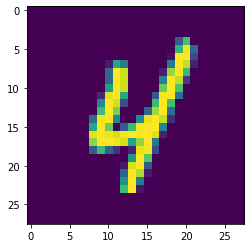

In [10]:
# Display a sample of the MNIST input and a sample prediction from the trained model
from random import randint
lucky_num = randint(0, 1000)
target_image = train_images[lucky_num:lucky_num+1]
print(target_image.shape)
predictions = model.predict(target_image)
print(np.argmax(predictions))
plt.imshow(np.reshape(target_image.astype(np.float32), (28, 28)))
plt.show(block=False)

### Make predictions

We create a black box classifier using the model trained above.

In [11]:
def predict(x):
    x = np.array(x)
    return model.predict(x)
    
# Create blackbox object
print(train_images[0].shape)
classifier = BlackBoxClassifier(predict, train_images[0].shape, 10, clip_values=(0, 255))

(784,)


(1, 784)


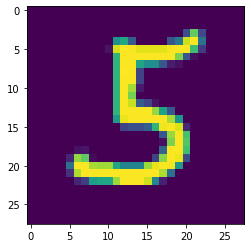

[[-11.709108   -1.3560646  -6.854515    4.0799847 -16.513319   16.354774
   -3.9070418 -18.832949   -1.8973945  -4.505822 ]]
Prediction from API is: 5


In [12]:
# Select target image and show prediction of the classifier for the target image
from random import randint
lucky_num = randint(0, 1000)
target_image =train_images[lucky_num].reshape(1, 784)
print(target_image.shape)
plt.imshow(np.reshape(target_image.astype(np.float32), (28, 28)))
plt.show(block=False)
print(classifier.predict(target_image))
print('Prediction from API is: ' + str(np.argmax(classifier.predict(target_image), axis=1)[0]))

### Generate black box HopSkipJump attack

This code makes use of the HopSkipJump classifier implementation and also the Classifier wrapper implementation taken from the Adversarial Robustness Toolbox library. This library can be found here: https://github.com/Trusted-AI/adversarial-robustness-toolbox

Firstly, we show how to conduct an untargetted attack, with 3 iterations of the HopSkipJumpAttack. This simply adds noise to the original image to make our victim classifier model misclassify the pertubed (noise added) image.

HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial image at step 0. L2 error 16.335516211183432 and class label 3.


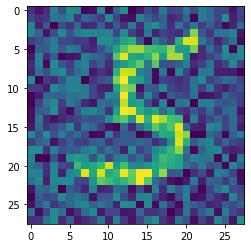

HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial image at step 10. L2 error 4.301245783255137 and class label 3.


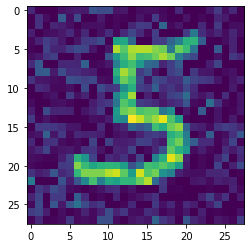

HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial image at step 20. L2 error 3.3263644770729064 and class label 3.


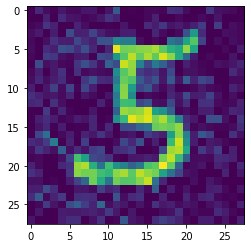

In [13]:
# Generate HopSkipJump attack against black box classifier
attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10
x_adv = None
for i in range(3):
    x_adv = attack.generate(x=np.array([target_image]), x_adv_init=x_adv)
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target_image, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(np.reshape(x_adv[0].astype(np.float32), (28, 28)))
    plt.show(block=False)
    
    attack.max_iter = iter_step

Next, we show how to conduct an targetted attack, with 3 iterations of the HopSkipJumpAttack. We specify a target label '7', and also a target image we initialize the pertubation. 

Target image: 


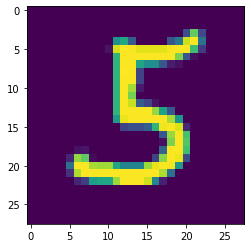

Adv image: 


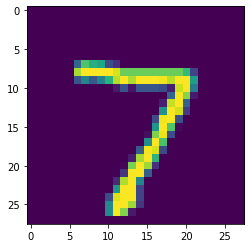

HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial image at step 0. L2 error 10.714331961487597 and class label 7.


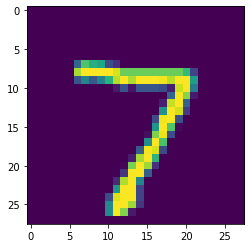

HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial image at step 10. L2 error 7.967506276066212 and class label 7.


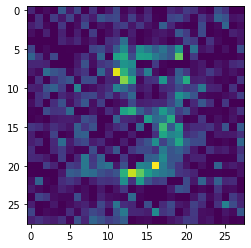

HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Generate HopSkipJump attack against black box classifier
attack = HopSkipJump(classifier=classifier, targeted=True, max_iter=0, max_eval=1000, init_eval=5)
target_label = np.array(test_images[:1])
print("Target image: ")
plt.imshow(np.reshape(target_image.astype(np.float32), (28, 28)))
plt.show(block=False)
print("Adv image: ")
plt.imshow(np.reshape(target_label.astype(np.float32), (28, 28)))
plt.show(block=False)
iter_step = 10
x_adv = target_label
for i in range(3):
    x_adv = attack.generate(x=np.array([target_image]), x_adv_init=x_adv, y=[7])
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target_image, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(np.reshape(x_adv[0].astype(np.float32), (28, 28)))
    plt.show(block=False)
    
    attack.max_iter = iter_step